In [1]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, Input, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random as rn

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
data_dir = "E:\Machine Learning\Deep Learning\my_batik\datatrain"
img_size = (224, 224)
batch_size = 32
epoch = 60
num_classes = 11

In [3]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip=True,
                                          rotation_range=40,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          validation_split = 0.2,
                                          )

validation_data_generator = ImageDataGenerator(rescale=1./255,
                                               validation_split = 0.2)
                                            
training_data = train_data_generator.flow_from_directory(data_dir,
                                                         target_size = img_size,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical',
                                                         subset = 'training',
                                                         shuffle = True,
                                                         color_mode = 'rgb')

validation_data = validation_data_generator.flow_from_directory(data_dir,
                                                                target_size = img_size,
                                                                batch_size = batch_size,
                                                                class_mode = 'categorical',
                                                                subset = 'validation',
                                                                shuffle = True,
                                                                color_mode = 'rgb')

Found 499 images belonging to 11 classes.


Found 119 images belonging to 11 classes.


In [4]:
def show_image_samples(gen):
    # Ensure the generator has class_indices attribute
    if hasattr(gen, 'class_indices'):
        test_dict = gen.class_indices
        classes = list(test_dict.keys())
    else:
        raise AttributeError("The provided generator does not have 'class_indices' attribute.")
    
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)  # show a maximum of 25 images

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, fontsize=16)
        plt.axis('off')
    
    plt.show()

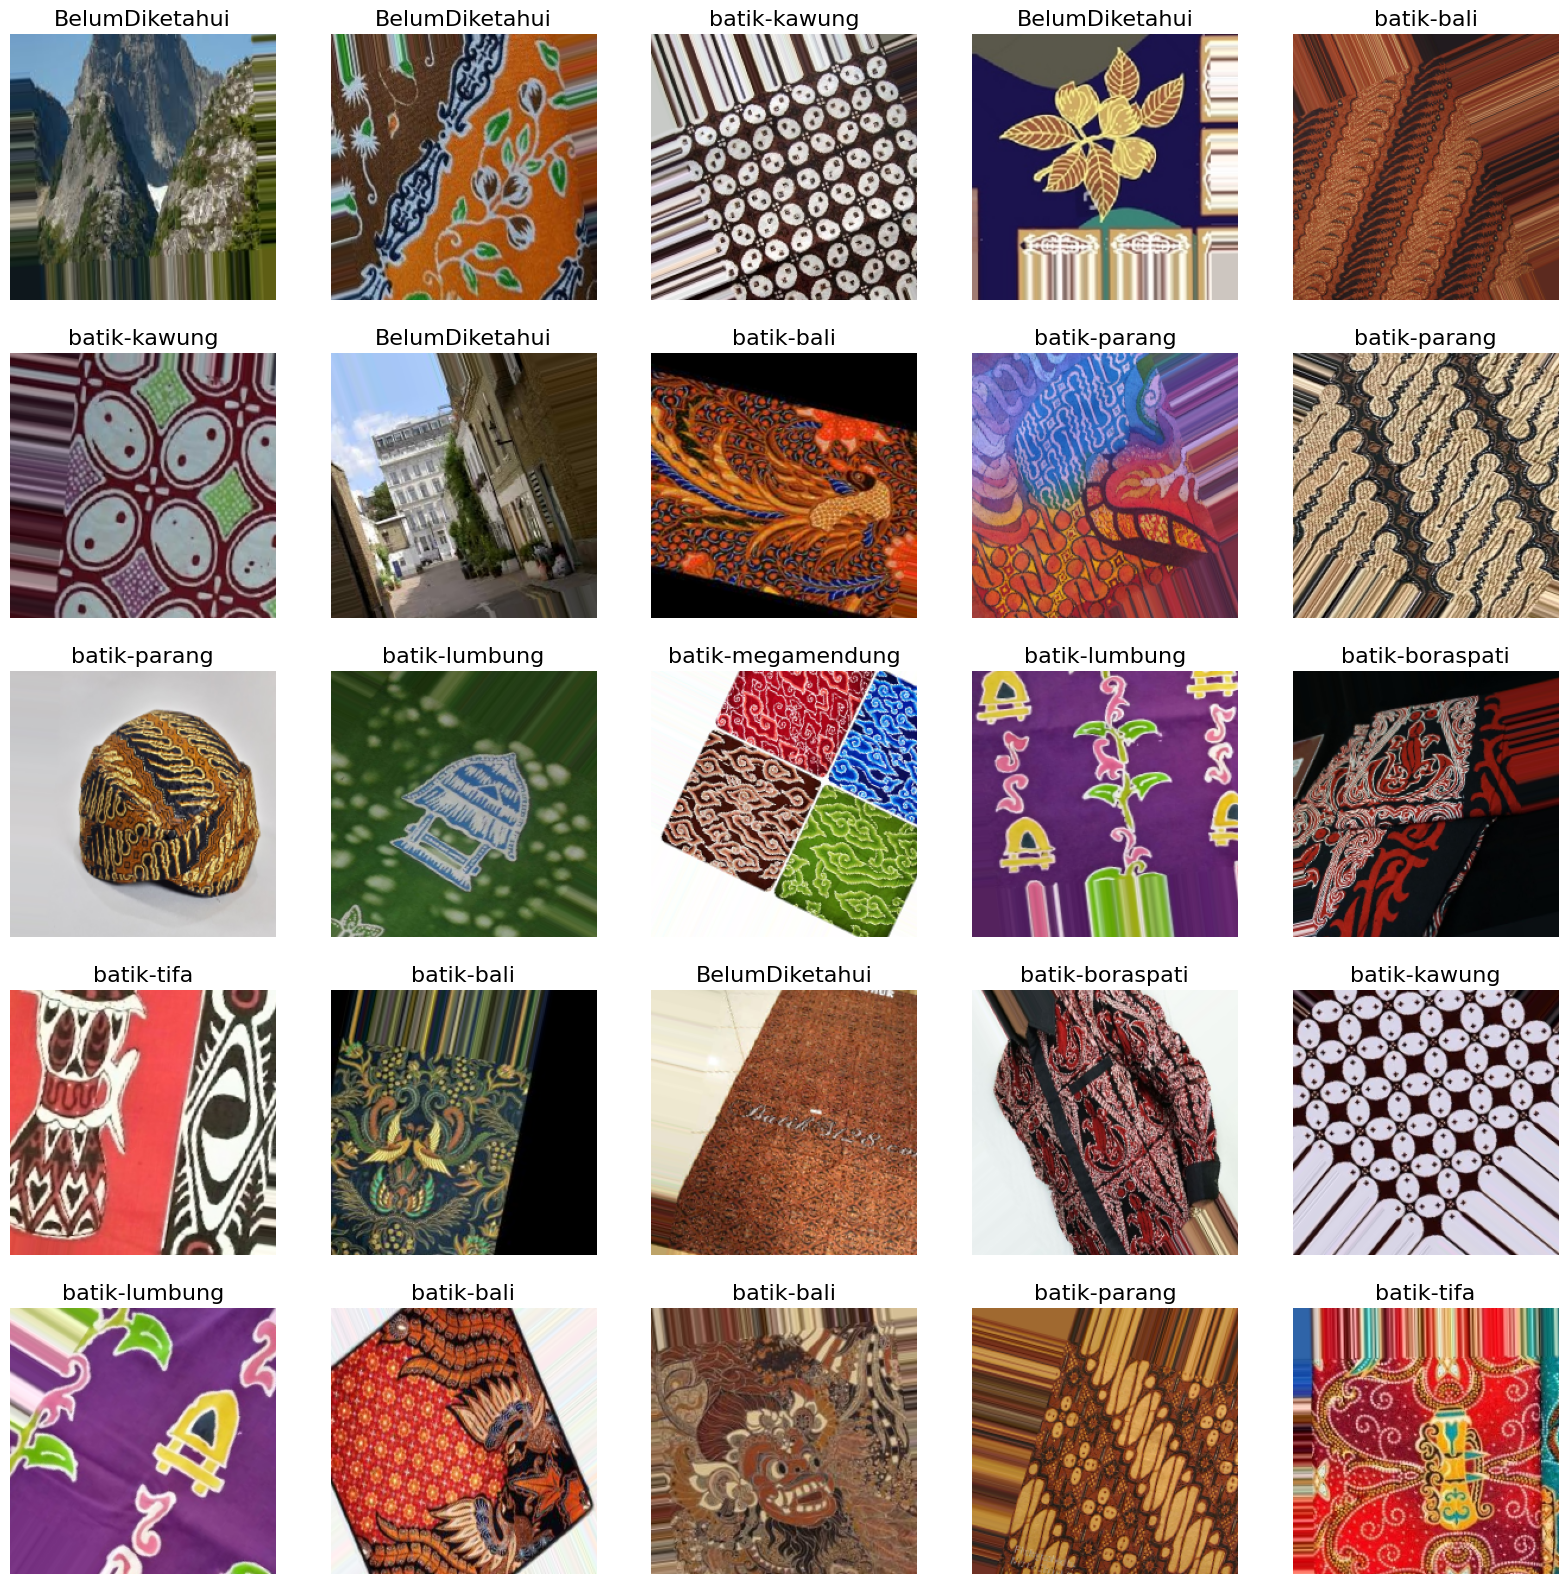

In [5]:
show_image_samples(training_data)

In [6]:
labels = np.unique(training_data.class_indices)
print(labels)

[{'BelumDiketahui': 0, 'batik-asmat': 1, 'batik-bali': 2, 'batik-boraspati': 3, 'batik-gadjah': 4, 'batik-kawung': 5, 'batik-lumbung': 6, 'batik-megamendung': 7, 'batik-parang': 8, 'batik-pekalongan': 9, 'batik-tifa': 10}]


In [7]:
classes_name = list(training_data.class_indices.keys())
classes_name

['BelumDiketahui',
 'batik-asmat',
 'batik-bali',
 'batik-boraspati',
 'batik-gadjah',
 'batik-kawung',
 'batik-lumbung',
 'batik-megamendung',
 'batik-parang',
 'batik-pekalongan',
 'batik-tifa']

In [8]:
df_labels = pd.DataFrame(list(labels[0].keys()), columns=['Nama Batik'])
df_labels['Class'] = pd.DataFrame(list(labels[0].values()))
df_labels

Nama Batik  Class
0      BelumDiketahui      0
1         batik-asmat      1
2          batik-bali      2
3     batik-boraspati      3
4        batik-gadjah      4
5        batik-kawung      5
6       batik-lumbung      6
7   batik-megamendung      7
8        batik-parang      8
9    batik-pekalongan      9
10         batik-tifa     10

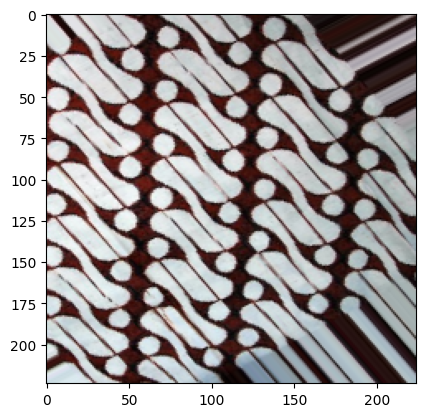

In [9]:
img, label = training_data[rn.randint(0, len(training_data))]
plt.imshow(img[0]) 

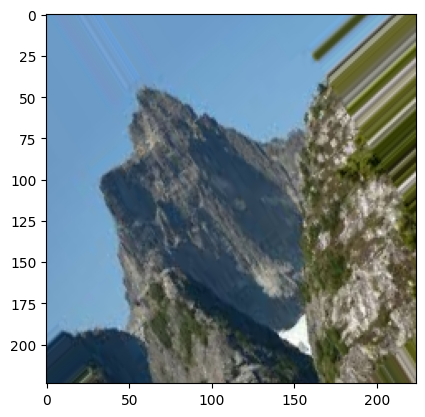

In [10]:
plt.imshow(training_data[0][0][0])

In [11]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [12]:
for layer in base_model.layers:
  layer.trainable = False 

# base_model.trainable = False

In [13]:
model = Sequential([
  Input(224,224,3),
  Conv2D(640, 3, activation='relu'),
  Maxpooling2D(),
  Conv2D(32, 3, activation='relu'),
  Maxpooling2D(),
  Flatten(),
  # base_model,
  GlobalAveragePooling2D(),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
])

In [14]:
model.build(input_shape=(None, 224, 224, 3))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,262,027 (12.44 MB)

 Trainable params: 33,163 (129.54 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [16]:
model.compile(optimizer= Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [18]:
save_model = ModelCheckpoint('./11ClassEpoch60dense64.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [19]:
print(training_data.samples)
print(training_data.class_indices)
print(training_data.filenames)
print(len(training_data))

499
{'BelumDiketahui': 0, 'batik-asmat': 1, 'batik-bali': 2, 'batik-boraspati': 3, 'batik-gadjah': 4, 'batik-kawung': 5, 'batik-lumbung': 6, 'batik-megamendung': 7, 'batik-parang': 8, 'batik-pekalongan': 9, 'batik-tifa': 10}
['BelumDiketahui\\1000030.jpg', 'BelumDiketahui\\1000031.jpg', 'BelumDiketahui\\1000032.jpg', 'BelumDiketahui\\1000035.jpg', 'BelumDiketahui\\1000037.jpg', 'BelumDiketahui\\1000039.jpg', 'BelumDiketahui\\100004.jpg', 'BelumDiketahui\\1000040.jpg', 'BelumDiketahui\\1000041.jpg', 'BelumDiketahui\\100005.jpg', 'BelumDiketahui\\100006.jpg', 'BelumDiketahui\\100007.jpg', 'BelumDiketahui\\100008.jpg', 'BelumDiketahui\\100009.jpg', 'BelumDiketahui\\11.jpg', 'BelumDiketahui\\12.jpg', 'BelumDiketahui\\13.jpg', 'BelumDiketahui\\14.jpg', 'BelumDiketahui\\15.jpg', 'BelumDiketahui\\16.jpg', 'BelumDiketahui\\1682389320129.jpg', 'BelumDiketahui\\17.jpg', 'BelumDiketahui\\18.jpg', 'BelumDiketahui\\19.jpg', 'BelumDiketahui\\2.jpg', 'BelumDiketahui\\20.jpg', 'BelumDiketahui\\21.jpg'

In [20]:
print(training_data.samples/batch_size)
print(training_data.samples//batch_size)
print(int(training_data.samples/batch_size))

15.59375
15
15


In [21]:
history = model.fit(training_data, validation_data=validation_data, epochs=epoch, verbose=1, batch_size=batch_size, callbacks=[save_model, lr, early_stop], steps_per_epoch= training_data.samples // batch_size)

Epoch 1/60


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.1251 - loss: 2.7654
Epoch 1: val_loss improved from inf to 2.22283, saving model to ./11ClassEpoch60dense64.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1258 - loss: 2.7510 - val_accuracy: 0.1849 - val_loss: 2.2228 - learning_rate: 0.0010
Epoch 2/60
 1/15 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.1562 - loss: 2.2475

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.22283 to 2.22117, saving model to ./11ClassEpoch60dense64.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.1562 - loss: 2.2475 - val_accuracy: 0.1765 - val_loss: 2.2212 - learning_rate: 0.0010
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.2308 - loss: 2.1880
Epoch 3: val_loss improved from 2.22117 to 2.09021, saving model to ./11ClassEpoch60dense64.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2313 - loss: 2.1853 - val_accuracy: 0.2941 - val_loss: 2.0902 - learning_rate: 0.0010
Epoch 4/60
 1/15 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - accuracy: 0.3125 - loss: 2.0144
Epoch 4: val_loss improved from 2.09021 to 2.07052, saving model to ./11ClassEpoch60dense64.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.3125 - loss: 2.0144 - val_accuracy: 0.3277 - val_loss: 2.0705 - learning_rate: 0.0010
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.2736 - loss: 2.0903
Epoch 5: val_loss improved

### Model Evaluate

In [22]:
def lossAcc(data):
  loss, accuracy = model.evaluate(data)

  print(f'Loss : {loss}')
  print(f'Accuracy : {accuracy}')

In [23]:
print(lossAcc(training_data))
print(lossAcc(validation_data))

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 899ms/step - accuracy: 0.8854 - loss: 0.5677
Loss : 0.529756486415863
Accuracy : 0.8877755403518677
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - accuracy: 0.7098 - loss: 0.9551
Loss : 1.0199005603790283
Accuracy : 0.680672287940979
None


In [24]:
def plot_history(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  plt.subplot(1,2,2)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  plt.show()

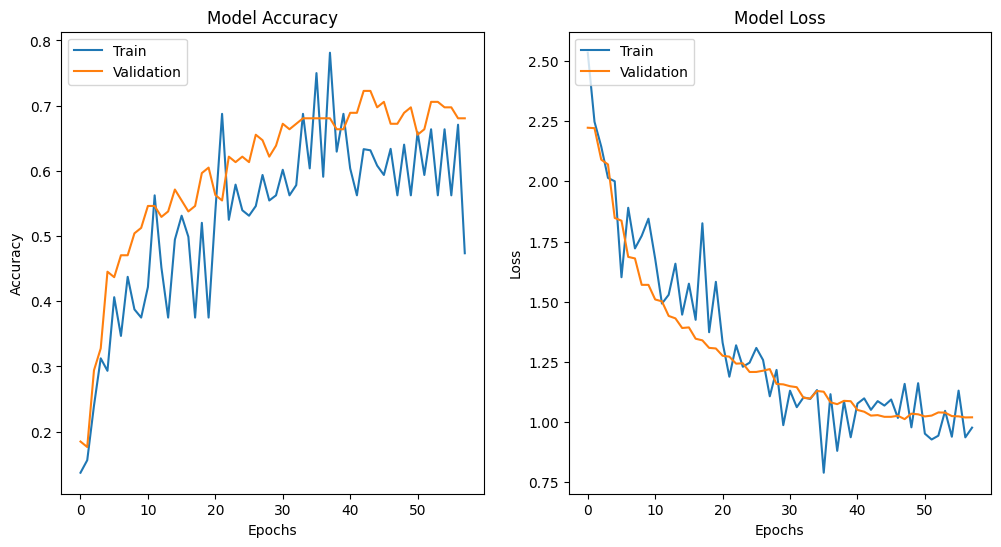

In [25]:
plot_history(history.history)

### Evaluate Model Validation data
#### Ga terlalu diperlukan

In [26]:
predict_data_val = model.predict(validation_data)
predict_data_val

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 738ms/step


array([[7.04725683e-02, 4.89437114e-03, 4.00691107e-03, ...,
        1.47471484e-02, 6.48970832e-04, 6.23377098e-04],
       [2.26128846e-01, 5.90660423e-03, 1.23844735e-01, ...,
        6.06777184e-02, 2.00366508e-02, 7.92895502e-04],
       [4.53651063e-02, 2.19534114e-02, 7.01295853e-01, ...,
        3.63760740e-02, 1.19125232e-01, 9.99452174e-03],
       ...,
       [7.23707897e-04, 3.96147952e-05, 1.33431022e-04, ...,
        4.61774413e-04, 4.62170737e-03, 4.77141584e-05],
       [1.70864817e-03, 1.32966888e-04, 1.74900831e-03, ...,
        1.49588694e-03, 2.64809635e-02, 5.09970414e-04],
       [1.00307716e-02, 3.51575174e-04, 2.23182561e-03, ...,
        7.15930641e-01, 9.25452972e-04, 4.64803379e-05]], dtype=float32)

In [27]:
y_pred = np.argmax(predict_data_val, axis=1)
y_pred

array([ 5,  5,  2, 10,  2,  2,  9,  8, 10,  7,  2,  8, 10,  6,  8,  2,  2,
        6,  2,  6,  5,  5,  0,  2,  9,  0,  2,  2,  5,  6,  0,  0,  8,  2,
        2,  5,  2,  8,  4,  4,  8,  0,  1,  7,  0,  2,  2,  9,  3,  5,  9,
        8,  0,  5,  7,  5,  0,  7,  7,  7,  9, 10,  8,  2,  4,  5,  7, 10,
        5,  2,  8,  7,  3,  0,  8,  7,  7,  2,  8,  6,  9,  7,  7,  1,  2,
        6,  5,  2,  2,  8,  4,  8,  8, 10,  2,  6,  3,  7,  8,  3,  5,  0,
        5,  5, 10,  0,  3,  0,  2,  4,  2,  1,  7,  2,  8,  2,  7,  7,  8],
      dtype=int64)

In [28]:
y_true = validation_data.classes
y_true

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10])

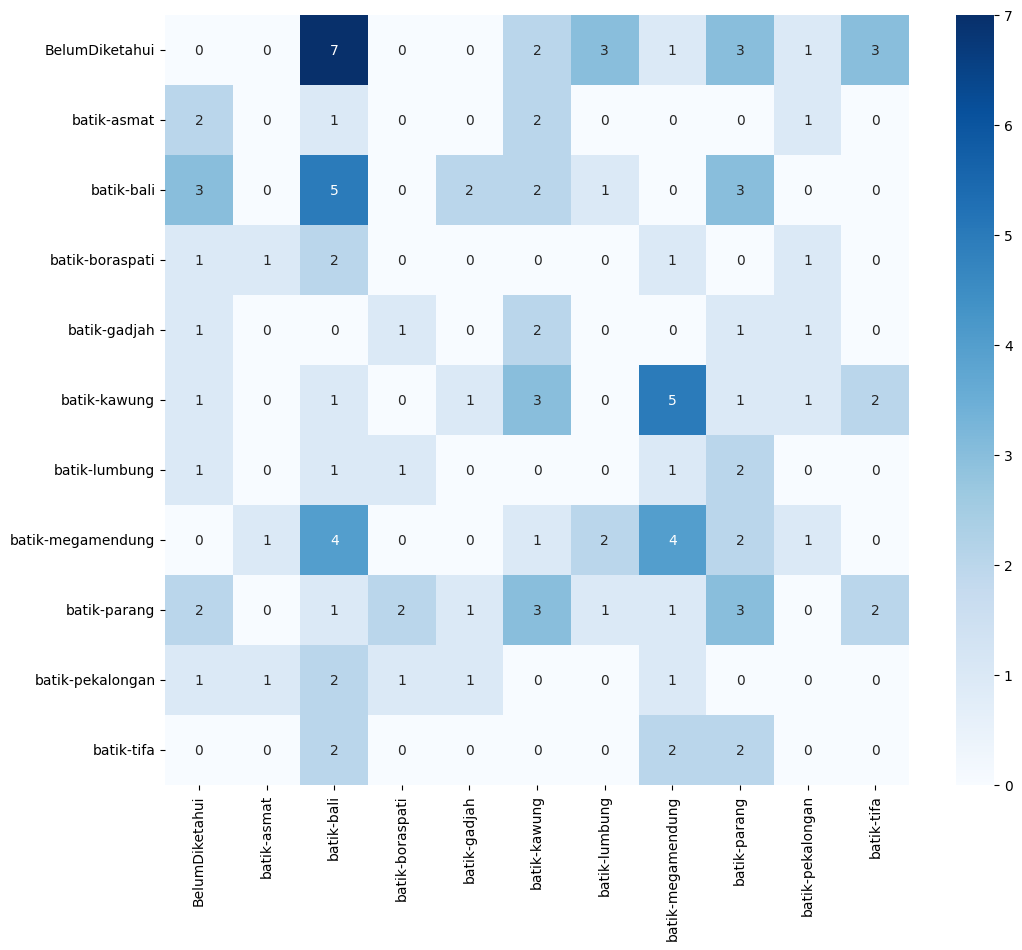

In [29]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=classes_name, yticklabels=classes_name, fmt='g', cmap="Blues")

plt.show()

In [30]:
cr = classification_report(y_true=y_true, y_pred=y_pred, target_names=classes_name)
print(cr)

                   precision    recall  f1-score   support

   BelumDiketahui       0.00      0.00      0.00        20
      batik-asmat       0.00      0.00      0.00         6
       batik-bali       0.19      0.31      0.24        16
  batik-boraspati       0.00      0.00      0.00         6
     batik-gadjah       0.00      0.00      0.00         6
     batik-kawung       0.20      0.20      0.20        15
    batik-lumbung       0.00      0.00      0.00         6
batik-megamendung       0.25      0.27      0.26        15
     batik-parang       0.18      0.19      0.18        16
 batik-pekalongan       0.00      0.00      0.00         7
       batik-tifa       0.00      0.00      0.00         6

         accuracy                           0.13       119
        macro avg       0.07      0.09      0.08       119
     weighted avg       0.11      0.13      0.11       119



### Test Data Evaluate

In [31]:
test_dir = 'E:\Machine Learning\Deep Learning\my_batik\datatest'

In [32]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(test_dir,
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'categorical',
                                               target_size = img_size,
                                               shuffle = False)

Found 163 images belonging to 11 classes.


In [33]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy : {test_acc}')
print(f'Test Loss : {test_loss}')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.5572 - loss: 1.4520
Test Accuracy : 0.650306761264801
Test Loss : 1.2621862888336182


In [34]:
predict_data_test = model.predict(test_data)
predict_data_test

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step


array([[0.15801132, 0.0431107 , 0.05011718, ..., 0.28666323, 0.00733538,
        0.01833779],
       [0.17642221, 0.00930322, 0.02411401, ..., 0.002453  , 0.00379342,
        0.07638416],
       [0.14621677, 0.02017808, 0.21399696, ..., 0.01103155, 0.05873084,
        0.16029364],
       ...,
       [0.18580045, 0.00238433, 0.00854687, ..., 0.00321073, 0.00219939,
        0.22853972],
       [0.01436391, 0.00523435, 0.16838671, ..., 0.00498879, 0.00573784,
        0.5272953 ],
       [0.02429527, 0.01202743, 0.04660023, ..., 0.00316372, 0.00195648,
        0.54540527]], dtype=float32)

In [35]:
y_pred = np.argmax(predict_data_test, axis=1)
y_pred

array([ 8,  6,  2,  8,  3,  8,  0,  0,  4,  0,  0,  2,  2,  6,  2,  3, 10,
        3,  6,  6,  0,  2,  0,  0,  2,  9,  2,  0,  2,  9,  3,  9,  9,  0,
        0,  3,  0,  6,  0,  5,  0,  0,  1,  5,  0,  6,  5,  1,  1,  1,  1,
        1,  1,  1,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  2,
        3,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  2,  2,  2,  2,  2,
        1,  2,  2,  2,  2,  2,  3,  2,  3,  3,  3,  3,  4,  4,  4,  4,  3,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  0,  6,  6,  4,  6,
        6,  6,  7,  1,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  2,  2,  7,  9,  3,  2,  2,  0,  9,  9,  8,  2,
        8,  2,  2, 10, 10, 10, 10, 10, 10, 10], dtype=int64)

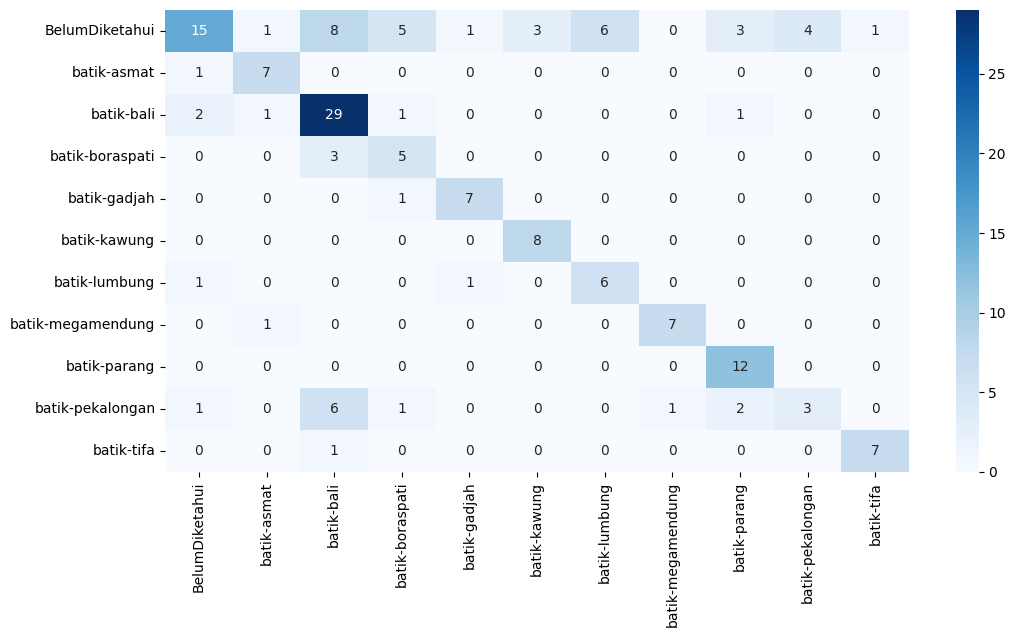

In [36]:
cm_test = confusion_matrix(test_data.classes, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
plt.show()

### Classification Report Data Test

In [37]:
print(classification_report(test_data.classes, y_pred, target_names=classes_name))

                   precision    recall  f1-score   support

   BelumDiketahui       0.75      0.32      0.45        47
      batik-asmat       0.70      0.88      0.78         8
       batik-bali       0.62      0.85      0.72        34
  batik-boraspati       0.38      0.62      0.48         8
     batik-gadjah       0.78      0.88      0.82         8
     batik-kawung       0.73      1.00      0.84         8
    batik-lumbung       0.50      0.75      0.60         8
batik-megamendung       0.88      0.88      0.88         8
     batik-parang       0.67      1.00      0.80        12
 batik-pekalongan       0.43      0.21      0.29        14
       batik-tifa       0.88      0.88      0.88         8

         accuracy                           0.65       163
        macro avg       0.66      0.75      0.68       163
     weighted avg       0.67      0.65      0.62       163



In [38]:
print(f1_score(test_data.classes, y_pred, average='macro'))
print(recall_score(test_data.classes, y_pred, average='macro'))

0.6835570719410037
0.7510341660842286


### Manual test one by one

#### Use load model

In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [40]:
modelDir = './model/11ClassEpoch60.keras'
imgDir = './ktp.jpg'

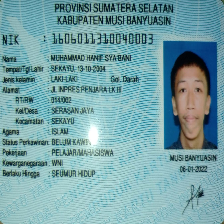

In [41]:
images= load_img(imgDir, target_size=img_size)
images

In [42]:
images_array = img_to_array(images)
# images

In [43]:
images_normalize = images_array / 255.0
# images

In [44]:
images_expand = np.expand_dims(images_normalize, axis=0)
# images

In [45]:
modelLoad = load_model(modelDir)

In [46]:
predict_img = model.predict(images_expand)
predict_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


array([[9.2994255e-01, 7.1594800e-04, 5.7576643e-03, 7.6065952e-04,
        1.0752473e-02, 3.5451919e-02, 8.5523096e-04, 9.9493183e-05,
        1.4415207e-02, 9.4291597e-04, 3.0603685e-04]], dtype=float32)

In [47]:
predict_model_load = modelLoad.predict(images_expand)
predict_model_load

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


array([[9.7915524e-01, 5.9350656e-05, 1.3990601e-04, 1.6877802e-04,
        9.2050815e-03, 4.0116804e-04, 3.0320245e-03, 3.3777999e-04,
        6.3615115e-03, 1.0414805e-03, 9.7587545e-05]], dtype=float32)

In [48]:
result = np.argmax(predict_img)
result

0

In [49]:
result_model_load = np.argmax(predict_model_load)
result_model_load

0

In [50]:
print(f'Hasil Model : {classes_name[result]}')
print(f'Hasil Model Load : {classes_name[result_model_load]}')

Hasil Model : BelumDiketahui
Hasil Model Load : BelumDiketahui
